In [6]:
import os
import joblib
from time import time
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, TimeDistributed
from tensorflow.keras import Input, Model, callbacks
from tensorflow.keras.utils import plot_model as plm
from tensorflow.keras.activations import swish
from keras.callbacks import CSVLogger

from tensorflow.compat.v1.keras.backend import set_session
from scikeras.wrappers import KerasRegressor
from tcn import TCN, tcn_full_summary

import sys
sys.path.insert(0, '../MODL/INC/')
from data_load import data_load


#-------------------------------------------------------------------------
# .. Set configure

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.compat.v1.Session(config=config))


#-------------------------------------------------------------------------
# .. Data set

element = 'ALLV'
name_list = "./SHEL/namelist.input"

# hp_lr = 0.009
# hp_pd = 'same'
# hp_ns = 1
# hp_dl = [1,2,4,8,16,32,48]
# hp_ldl = hp_dl[-1] # last dilation factor to make name of save model
# hp_bn = True
# hp_nf = 80
# hp_dr = 0.07
# hp_ks = 6

# input_size = 6
# output_size = 2
# num_fct = 48
# batch_size = 8
# n_iter_search = 20
# num_epoch = 600
dev_stn_id = 47105
#dev_stn_id = 875
#tran_data_per = "2101_2104_2201_2204"
#test_data_per = "2301_2304"

exp_name = "CNTL"
csv_outdir = './DAOU/LOSS/' + exp_name + '/'
model_outdir = './DAOU/MODL/' + exp_name + '/'
scalr_outdir = './DAOU/SCAL/' + exp_name + '/'
gifd_outdir = './GIFD/' + exp_name + '/'
log_outdir = './DAOU/LOGF/' + exp_name + '/'


if os.path.exists(csv_outdir) != True: os.makedirs(csv_outdir)
if os.path.exists(model_outdir) != True: os.makedirs(model_outdir)
if os.path.exists(scalr_outdir) != True: os.makedirs(scalr_outdir)
if os.path.exists(gifd_outdir) != True: os.makedirs(gifd_outdir)
if os.path.exists(log_outdir) != True: os.makedirs(log_outdir)


nwp_file = f"../DAIO/nwp_data_{dev_stn_id}"
obs_file = f"../DAIO/obs_data_{dev_stn_id}"

sel_dm_nwp_train, sel_dm_nwp_test, dm_obs_train, dm_obs_test = data_load(nwp_file, obs_file, dev_stn_id) # 875일때 적용 필요

================================================== load data shape
(868, 49, 20)
(868, 49, 2)
================================================== split data shape
(109, 49, 20)
(109, 49, 2)
(61, 49, 20)
(61, 49, 2)
결측 합계:  1
결측 index= [23]
shape of after drop
(108, 49, 20)
(108, 49, 2)
결측 합계:  5
결측 index= [16, 17, 18, 19, 15]
test_nwp missing
[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan n

In [7]:
# .. 스케일링 및 데이터 분할
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import sys
sys.path.insert(0, './INC')
from step_sampling_for_date import step_sampling_for_date
from hist_and_kde_for_split import hist_and_kde_for_split, hist_and_kde_for_split_UV

#-------------------------------------------------------------------------
# .. Normalize

output_size = 2

# .. initialaize
tr_b, tr_s, tr_f = sel_dm_nwp_train.shape[0], sel_dm_nwp_train.shape[1], sel_dm_nwp_train.shape[2]      
ts_b, ts_s, ts_f = sel_dm_nwp_test.shape[0], sel_dm_nwp_test.shape[1], sel_dm_nwp_test.shape[2]      

# .. get restorator with obs range
nwp_scaler = MinMaxScaler()   # copy default true
obs_scaler = MinMaxScaler()
nwp_scaler.fit(sel_dm_nwp_train.view().reshape(tr_b*tr_s, tr_f))
obs_scaler.fit(dm_obs_train.view().reshape(tr_b*tr_s, output_size))

# .. feature normalize   ( train seq, feature = test seq, feature )
nor_dm_nwp_train = nwp_scaler.transform(sel_dm_nwp_train.reshape(tr_b*tr_s, tr_f))
nor_dm_nwp_train = nor_dm_nwp_train.reshape(tr_b,tr_s,tr_f)
nor_dm_nwp_test = nwp_scaler.transform(sel_dm_nwp_test.reshape(ts_b*ts_s, ts_f))
nor_dm_nwp_test = nor_dm_nwp_test.reshape(ts_b,ts_s,ts_f)

nor_dm_obs_train = obs_scaler.transform(dm_obs_train.reshape(tr_b*tr_s, output_size))
nor_dm_obs_train = nor_dm_obs_train.reshape(tr_b,tr_s, output_size)
nor_dm_obs_test = obs_scaler.transform(dm_obs_test.reshape(ts_b*ts_s, output_size))
nor_dm_obs_test = nor_dm_obs_test.reshape(ts_b,ts_s, output_size)


print ('---------- Final training data shape')
print(type(nor_dm_nwp_train))
print ('tran nwp : ', nor_dm_nwp_train.shape)
print ('tran obs : ', nor_dm_obs_train.shape)
print ('test nwp : ', nor_dm_nwp_test.shape)
print ('test obs : ', nor_dm_obs_test.shape)


---------- Final training data shape
<class 'numpy.ndarray'>
tran nwp :  (108, 48, 6)
tran obs :  (108, 48, 2)
test nwp :  (56, 48, 6)
test obs :  (56, 48, 2)


In [8]:
#-------------------------------------------------------------------------
# .. Model load
from tensorflow.keras.models import load_model
#model_name = "../MODL/DAOU/MODL/CNTL/tcn_modl_var6_e1000_bs8_lr0.009_nf87_pdsame_ks6_dr0.07_dl48_ns1_2101_2104_2201_2204_47105.h5"

#hyper band
#model_name = f"../MODL/DAOU/MODL/CNTL/tcn_modl_var6_e1000_bs8_lr0.009_nf85_pdsame_ks3_dr0.07_dl4_ns1_2101_2104_2201_2204_{dev_stn_id}.h5"
#model_name = f"../MODL/DAOU/MODL/CNTL/tcn_modl_var6_e1000_bs8_lr0.009_nf55_pdsame_ks3_dr0.07_dl4_ns1_2101_2104_2201_2204_{dev_stn_id}.h5"
#bayesian
model_name = f"../MODL/DAOU/MODL/CNTL/tcn_modl_var6_e1000_bs8_lr0.009_nf95_pdsame_ks3_dr0.07_dl4_ns1_2101_2104_2201_2204_{dev_stn_id}.h5"
#model_name = f"../MODL/DAOU/MODL/CNTL/tcn_modl_var6_e1000_bs8_lr0.009_nf100_pdsame_ks3_dr0.07_dl4_ns1_2101_2104_2201_2204_{dev_stn_id}.h5"

print ("load_model: ", model_name)
model = load_model(model_name, custom_objects={'TCN':TCN} )

# train
nor_pred_train_y = model.predict(nor_dm_nwp_train)
inv_pred_train = obs_scaler.inverse_transform(nor_pred_train_y.reshape(tr_b*tr_s, output_size))
inv_pred_train = inv_pred_train.reshape(tr_b,tr_s, output_size)
print(inv_pred_train.shape)
# test
nor_pred_test_y = model.predict(nor_dm_nwp_test)
inv_pred_test = obs_scaler.inverse_transform(nor_pred_test_y.reshape(ts_b*ts_s, output_size))
inv_pred_test = inv_pred_test.reshape(ts_b,ts_s, output_size)
print(inv_pred_test.shape)

load_model:  ../MODL/DAOU/MODL/CNTL/tcn_modl_var6_e1000_bs8_lr0.009_nf95_pdsame_ks3_dr0.07_dl4_ns1_2101_2104_2201_2204_47105.h5
4/4 [==============================] - 1s 34ms/step
(108, 48, 2)
2/2 [==============================] - 0s 95ms/step
(56, 48, 2)


In [9]:
set_dates_1 = pd.date_range('2023-01-01 09:00:00', '2023-01-31 09:00:00', freq='D')
set_dates_4 = pd.date_range('2023-04-01 09:00:00', '2023-04-30 09:00:00', freq='D')
print("있어야할 day수: ", len(set_dates_1))
print("있어야할 day수: ", len(set_dates_4))

print(type(set_dates_1))

combined_series = set_dates_1.union(set_dates_4)
print(np.where(combined_series=='2023-01-16 09:00:00')[0])

#print(combined_series.get_loc("2021-01-14 09:00:00"))

있어야할 day수:  31
있어야할 day수:  30
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
[15]


train acc ==================================================
        u_bias    v_bias    u_rmse    v_rmse  spd_bias  spd_rmse    cosine
ldps -0.037264  0.099751  2.520820  2.448330  1.412082  2.412164  0.524739
tcnm -0.046285 -0.214600  0.302423  0.351108  0.064380  0.354333  0.746597
test acc ==================================================
        u_bias    v_bias    u_rmse    v_rmse  spd_bias  spd_rmse    cosine
ldps -0.590387  1.412058  2.871175  3.295231  1.236993  2.431277  0.268869
tcnm -0.275115  1.073973  1.748978  1.806671 -0.469686  1.397886  0.390812


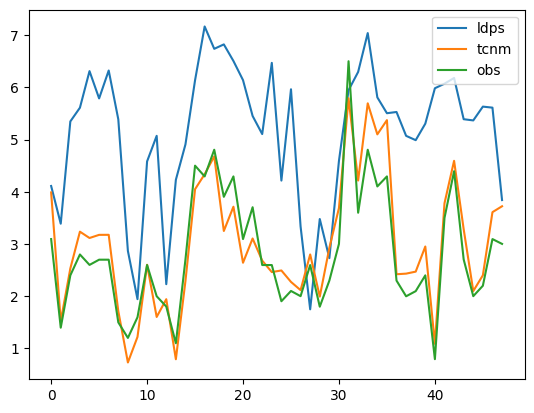

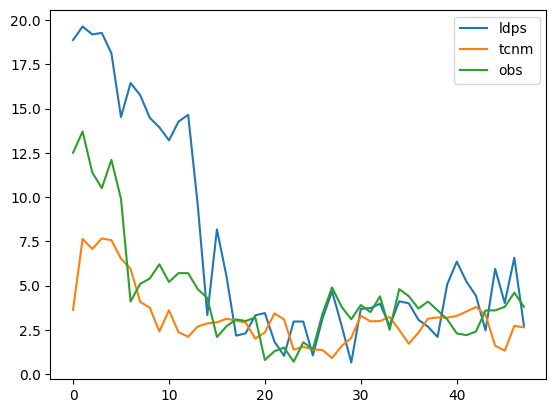

In [10]:
import numpy as np
import pandas as pd
from tensorflow.keras import metrics
%matplotlib inline

sys.path.insert(0, '../MODL/INC/')
from calc_stastics import bias_rmse
from uv_to_wind import uv_to_wind



def calc_bias(pred, target):
    bias = pred - target
    mean_bias = np.mean(bias, axis=0)
    return mean_bias


def calc_rmse(pred, target):
    se = (pred - target)**2
    rmse = np.sqrt( np.mean(se, axis=0) )
    return rmse



def calc_error(nwp, pred, obs, dev_stn_id):

    if dev_stn_id == 875:
        set_u_idx = 0
        set_v_idx = 1
    else:
        set_u_idx = 1
        set_v_idx = 2

    ldps_u_bias = calc_bias(nwp[:,:,set_u_idx], obs[:,:,0])
    ldps_v_bias = calc_bias(nwp[:,:,set_v_idx], obs[:,:,1])
    tcnm_u_bias = calc_bias(pred[:,:,0], obs[:,:,0])
    tcnm_v_bias = calc_bias(pred[:,:,1], obs[:,:,1])
    ldps_u_rmse = calc_rmse(nwp[:,:,set_u_idx], obs[:,:,0])
    ldps_v_rmse = calc_rmse(nwp[:,:,set_v_idx], obs[:,:,1])
    tcnm_u_rmse = calc_rmse(pred[:,:,0], obs[:,:,0])
    tcnm_v_rmse = calc_rmse(pred[:,:,1], obs[:,:,1])

    cosine_s = metrics.CosineSimilarity(axis=1)
    cosine_s.update_state(nwp[:,:,set_u_idx:set_v_idx+1].reshape(-1,2), obs[:,:,0:2].reshape(-1,2))
    ldps_w_coss = cosine_s.result().numpy()
    cosine_s.update_state(pred[:,:,:].reshape(-1,2), obs[:,:,0:2].reshape(-1,2))
    tcnm_w_coss = cosine_s.result().numpy()

    ndim_uv_to_wind = np.vectorize(uv_to_wind)
    nwp_spd, nwp_dir = ndim_uv_to_wind(nwp[:,:,set_u_idx], nwp[:,:,set_v_idx])
    prd_spd, prd_dir = ndim_uv_to_wind(pred[:,:,0], pred[:,:,1])
    obs_spd, obs_dir = ndim_uv_to_wind(obs[:,:,0], obs[:,:,1])

    #print(nwp_spd.shape)
    #print(prd_spd.shape)
    #print(obs_spd.shape)

    
    ldps_spd_bias = calc_bias(nwp_spd[:,:], obs_spd[:,:])
    tcnm_spd_bias = calc_bias(prd_spd[:,:], obs_spd[:,:])
    ldps_spd_rmse = calc_rmse(nwp_spd[:,:], obs_spd[:,:])
    tcnm_spd_rmse = calc_rmse(prd_spd[:,:], obs_spd[:,:])
    

    error_put = {'u_bias': [np.mean(ldps_u_bias), np.mean(tcnm_u_bias)],
                 'v_bias': [np.mean(ldps_v_bias), np.mean(tcnm_v_bias)],
                 'u_rmse': [np.mean(ldps_u_rmse), np.mean(tcnm_u_rmse)],
                 'v_rmse': [np.mean(ldps_v_rmse), np.mean(tcnm_v_rmse)],
                 'spd_bias': [np.mean(ldps_spd_bias), np.mean(tcnm_spd_bias)],
                 'spd_rmse': [np.mean(ldps_spd_rmse), np.mean(tcnm_spd_rmse)],
                 'cosine': [np.mean(ldps_w_coss), np.mean(tcnm_w_coss)]
              }
    
    error_df = pd.DataFrame(error_put, index=['ldps', 'tcnm'])
    print(error_df)

    #plot case
    sel_time = -20
    put_df = {'ldps':nwp_spd[sel_time,:], 'tcnm':prd_spd[sel_time,:], 'obs': obs_spd[sel_time,:] }
    df = pd.DataFrame(data = put_df)
    df.plot.line()

print("train acc","="*50)
calc_error(sel_dm_nwp_train, inv_pred_train, dm_obs_train, dev_stn_id)
print("test acc","="*50)
calc_error(sel_dm_nwp_test, inv_pred_test, dm_obs_test, dev_stn_id)






